In [110]:
import glob
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

# Get the amount of points received by experiment, execution and episode

In [64]:
cols = ['experiment', 'execution', 'episode', 'point']
result = pd.DataFrame(columns=cols)
for f in glob.glob("./execution/*/*/total_point.npy"):
    path = f.split('/')
    exp = path[2].split('_')[1]
    exec = path[3].split('_')[1]
    points = np.load(f)
    episodes = range(1, 1000+1)
    experiment = pd.DataFrame({
        'experiment': [int(exp) for _ in episodes],
        'execution': [int(exec) for _ in episodes],
        'episode': [i for i in episodes],
        'point': points,
    })
    result = pd.concat([result, experiment])
result = result.sort_values(by=cols).reset_index(drop=True)

In [82]:
result.tail()

,experiment,execution,episode,point
19995,4,5,996,16.0
19996,4,5,997,6.0
19997,4,5,998,3.0
19998,4,5,999,12.0
19999,4,5,1000,22.0


## Point average by experiment

In [67]:
result[['experiment','point']].groupby(['experiment']).mean()

,point
experiment,
1,2.7840
2,4.8602
3,4.3758
4,7.1172


## Point average by experiment and execution

In [69]:
result[['experiment','execution','point']].groupby(['experiment', 'execution']).mean()

point
experiment execution        
1          1           2.644
           2           4.044
           3           2.481
           4           2.340
           5           2.411
2          1          11.091
           2           4.465
           3           3.907
           4           2.250
           5           2.588
3          1           4.646
           2           5.433
           3           4.248
           4           3.632
           5           3.920
4          1           2.447
           2          10.190
           3          12.935
           4           4.158
           5           5.856

## Point average by experiment for the last hundred episodes

In [93]:
result.loc[result['episode'] > 900][['experiment','execution','point']]

,experiment,execution,point
900,1,1,2.0
901,1,1,2.0
902,1,1,2.0
903,1,1,2.0
904,1,1,5.0
...,...,...,...
19995,4,5,16.0
19996,4,5,6.0
19997,4,5,3.0
19998,4,5,12.0


In [97]:
result.loc[result['episode'] > 900]\
[['experiment','execution','point']].\
groupby(['experiment', 'execution']).mean()

point
experiment execution       
1          1           2.93
           2           4.88
           3           2.95
           4           2.27
           5           2.68
2          1          16.06
           2           5.07
           3           4.22
           4           2.24
           5           2.88
3          1           4.76
           2           7.28
           3           4.25
           4           5.32
           5           5.20
4          1           2.58
           2          17.75
           3          18.20
           4           3.87
           5          11.00

# Get confidence of intervals each 100 episodes

In [132]:
result_ci = pd.DataFrame(columns=['experiment','mean','ci95_hi','ci95_lo','percentile'])
for k in range (0, 10):
    stats = result.loc[(result['episode'] >= 100*k) & (result['episode'] < 100*k+100)]\
        [['experiment','point']].\
        groupby(['experiment']).agg(['mean', 'count', 'std']).sort_values(['experiment'])

    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))

    obs = pd.DataFrame({
        'experiment': range(1,5),
        'mean': stats['point']['mean'],
        'ci95_hi': ci95_hi,
        'ci95_lo': ci95_lo,
        'percentile': (k+1)*10
    })

    result_ci = pd.concat([result_ci, obs])

In [135]:
result_ci.tail()

,experiment,mean,ci95_hi,ci95_lo,percentile
4,4,9.868,10.52945,9.20655,90
1,1,3.144,3.318587,2.969413,100
2,2,6.096,6.61258,5.57942,100
3,3,5.382,5.635087,5.128913,100
4,4,10.656,11.349046,9.962954,100


# Plot the Confidence intervals each 100 episodes

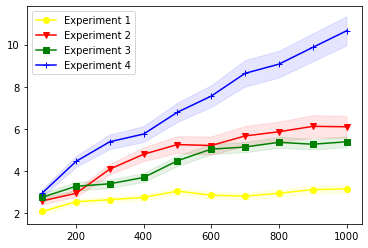

In [178]:
# Plot the sinus function
exp1 = result_ci.loc[result_ci['experiment']==1]
exp2 = result_ci.loc[result_ci['experiment']==2]
exp3 = result_ci.loc[result_ci['experiment']==3]
exp4 = result_ci.loc[result_ci['experiment']==4]

plt.plot(exp1['percentile']*10, exp1['mean'], c='yellow', marker='o', label='Experiment 1')
plt.fill_between([i*10 for i in exp1['percentile']], [i for i in exp1['ci95_lo']], [i for i in exp1['ci95_hi']], color='yellow', alpha=.1)

plt.plot(exp2['percentile']*10, exp2['mean'], c='red', marker='v', label='Experiment 2')
plt.fill_between([i*10 for i in exp2['percentile']], [i for i in exp2['ci95_lo']], [i for i in exp2['ci95_hi']], color='red', alpha=.1)

plt.plot(exp3['percentile']*10, exp3['mean'], c='green', marker='s', label='Experiment 3')
plt.fill_between([i*10 for i in exp3['percentile']], [i for i in exp3['ci95_lo']], [i for i in exp3['ci95_hi']], color='green', alpha=.1)

plt.plot(exp4['percentile']*10, exp4['mean'], c='blue', marker='+', label='Experiment 4')
plt.fill_between([i*10 for i in exp4['percentile']], [i for i in exp4['ci95_lo']], [i for i in exp4['ci95_hi']], color='blue', alpha=.1)

plt.legend(loc='upper left')
plt.show()